In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('talk')

In [2]:
import xlsxwriter

In [3]:
RANDOM_STATE = 71117
OUTPUT_DIR = '/output'
DATA_DIR = '/data'

# Load the dataset

In [4]:
with open(os.path.join(DATA_DIR, 'external', 'interpro', 'ank-repeat-proteins.txt')) as f:
    ank_repeat_ids = frozenset(map(lambda x: x.strip(), f.readlines()))

In [5]:
data = pd.read_table(os.path.join(DATA_DIR, 'raw/proteinGroups.txt.gz')).set_index('Protein IDs')

First, log2 the ratios

In [6]:
COL_RATIO_FORWARD = 'Ratio H/L normalized F'
COL_RATIO_REVERSE = 'Ratio H/L normalized R'

COL_RATIO_LOG2_FORWARD = 'Ratio H/L normalized F (log2)'
COL_RATIO_LOG2_REVERSE = 'Ratio H/L normalized R (log2)'

data[COL_RATIO_LOG2_FORWARD] = data[COL_RATIO_FORWARD].apply(np.log2)
data[COL_RATIO_LOG2_REVERSE] = data[COL_RATIO_REVERSE].apply(np.log2)

Annotate proteins that contain ANK repeat

In [7]:
data['Contains ANK repeat'] = data['Majority protein IDs'].str.split(';', expand=True).stack().isin(ank_repeat_ids).groupby('Protein IDs').any()

Identify potential misidentifications:

In [8]:
columns_to_filter = ['Potential contaminant', 'Reverse', 'Only identified by site']
potentially_misentified = pd.Series(False, index=data.index)

for column in columns_to_filter:
    potentially_misentified |= data[column] == '+'
    
data['Potentially misidentified'] = potentially_misentified

Find out which proteins have both ratios in the dataset

In [9]:
data['Has both ratios'] = (~data[[COL_RATIO_LOG2_FORWARD, COL_RATIO_LOG2_REVERSE]].isnull()).all(axis=1)

Remove proteins that are not interesting

In [10]:
data.to_csv(os.path.join(OUTPUT_DIR, 'dataset.full.csv'))

len_before = len(data)
data = data[~data['Potentially misidentified']]
len_after = len(data)

print('Artefact! Removing {:,}/{:,} ({:.2%}) proteins as they are potential misidentifications'.format(len_before - len_after,
                                                                                                       len_before,
                                                                                                       (len_before - len_after) / len_before
                                                                                                       ))
len_before = len(data)
data = data[data['Has both ratios']]
len_after = len(data)

print('Artefact! Removing {:,}/{:,} ({:.2%}) proteins as they do not have both F and R ratios'.format(len_before - len_after,
                                                                                                       len_before,
                                                                                                       (len_before - len_after) / len_before
                                                                                                       ))


Artefact! Removing 26/1,437 (1.81%) proteins as they are potential misidentifications
Artefact! Removing 76/1,411 (5.39%) proteins as they do not have both F and R ratios


ANK repeat containing genes

In [11]:
data['Contains ANK repeat'].value_counts()

False    1323
True       12
Name: Contains ANK repeat, dtype: int64

In [12]:
data.loc[data['Contains ANK repeat'], 'Gene names'].value_counts()

BCORL1      2
EHMT1       1
BCOR        1
ANKRD11     1
MPHOSPH8    1
BARD1       1
EHMT2       1
RFXANK      1
NFKBIL1     1
ANKRD32     1
TONSL       1
Name: Gene names, dtype: int64

Annotate interesting protein groups

In [13]:
GROUP_ANNOTATIONS = {
    
     # BRCA1
    'BRCA1': 'BRCA1',
    'FAM175A': 'BRCA1',
    'BARD1': 'BRCA1',
    'BRE': 'BRCA1', # labelled as BRCC45
    'UIMC1': 'BRCA1', # labelled as RAP80
    'FAM175A': 'BRCA1', # labelled as ABRAXAS1
    'BRCC3': 'BRCA1', # labelled as BRCC36,
    'BABAM1': 'BRCA1', # labelled as MERIT40
    
    # RAD18/SLF
    'RAD18': 'RAD18/SLF',  # Labelled as RAD18/RNF73
    'ANKRD32': 'RAD18/SLF', # Labelled as SLF1/ANKRD32,
    'FAM178A': 'RAD18/SLF', # Labelled as SLF2/FAM178A
    
    # TONSL
    'TONSL': 'TONSL',
    #'MMS22L': 'TONSL' # Not in the data :(
    
    
    # ORC
    'ORC1': 'ORC',
    'ORC2': 'ORC',
    'ORC3': 'ORC',
    'ORC4': 'ORC',
    'ORC5': 'ORC',
    #'ORC6': 'ORC',
    'LRWD1': 'ORC'
}

In [14]:
data['Protein group'] = data['Gene names'].apply(lambda x: GROUP_ANNOTATIONS.get(x, 'Other'))

Create a set of labels

In [15]:
data['Label'] = data['Gene names']
data.loc[data['Label'].isnull(), 'Label'] = data.loc[data['Label'].isnull(), 'Majority protein IDs'] 

In [16]:
LABEL_REPLACEMENT = {
    
     # BRCA1 members
    'BRE': 'BRCC45',
    'UIMC1': 'RAP80',
    'FAM175A': 'ABRAXAS1',
    'BRCC3': 'BRCC36',
    'BABAM1': 'MERIT40',
    
     # RAD18/SLF members
     'RAD18': 'RAD18/RNF73',
     'ANKRD32': 'SLF1/ANKRD32',
     'FAM178A': 'SLF2/FAM178A',
    
     # Histones
    'HIST1H2AD;HIST1H2AJ;HIST1H2AH;H2AFJ;HIST1H2AG;HIST2H2AC;HIST2H2AA3;H2AFX': 'H2A¹',
    'HIST3H2A;HIST1H2AB;HIST1H2AC': 'H2A²',
    'H2AFV;H2AFZ': 'H2A³', 
    'HIST1H3A;HIST2H3A;HIST3H3;HIST2H3PS2': 'H3',
    'HIST1H4A': 'H4',
    'HIST1H2BK;H2BFS': 'H2B¹',
    'HIST1H2BC': 'H2B²',
    
    
}

In [17]:
data['Label'] = data['Label'].apply(lambda x: LABEL_REPLACEMENT.get(x, x))

In [18]:
data.loc[data['Contains ANK repeat'], 'Label'] = '*' + data.loc[data['Contains ANK repeat'], 'Label']

Change the order of columns as it makes more sense in the output

In [19]:
PRIORITY_COLUMNS = ['Label', 'Gene names', 'Protein names', 'Protein group', 
                    'Contains ANK repeat', 'Potentially misidentified', 'Has both ratios',
                    COL_RATIO_LOG2_FORWARD, COL_RATIO_LOG2_REVERSE]


data = data[PRIORITY_COLUMNS + list(data.columns.difference(PRIORITY_COLUMNS))]

Sort data by max(abs(forward, reverse)))

In [20]:
data = data.loc[data[[COL_RATIO_LOG2_FORWARD, COL_RATIO_LOG2_REVERSE]].abs().max(axis=1).sort_values(ascending=False).index]

Write CSV

In [21]:
data.to_csv(os.path.join(OUTPUT_DIR, 'data.processed.csv'))

# Scatterplot

## Plotting, main figure

In [22]:
%load_ext rpy2.ipython

In [23]:
%%R
require('ggplot2')
require('ggrepel')
require('ggExtra')
require('grid')

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggrepel

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggExtra

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: grid

  warnings.warn(x, RRuntimeWarning)


In [24]:
%%R
source('scatterplot.R')

In [25]:
COL_X = COL_RATIO_LOG2_FORWARD
COL_Y = COL_RATIO_LOG2_REVERSE
COL_LABEL = 'Label'
COL_GROUP = 'Protein group'
COL_GENE = 'Gene names'
COL_ANK_REPEAT = 'Contains ANK repeat'

LABEL_PLOT_THRESHOLD = 1.4

def prepare_data_for_plot(limits):

    # Smaller df -> faster load into R
    # Also renaming the columns as python deals with the names much better than R does

    df_plot = data[[COL_X, COL_Y, COL_LABEL, COL_GROUP, COL_GENE, COL_ANK_REPEAT]].copy()
    df_plot = df_plot.rename(columns={COL_X: 'x',
                                      COL_Y: 'y',
                                      COL_GENE: 'gene',
                                      COL_LABEL: 'label',
                                      COL_GROUP: 'group',
                                      COL_ANK_REPEAT: 'ank_repeat'})



    out_of_limits_mask = ~(df_plot['x'].between(*limits) & df_plot['y'].between(*limits))
    out_of_limits = df_plot[out_of_limits_mask]

    if len(out_of_limits):
        print('{:,} proteins out of plot limits: '.format(len(out_of_limits)))

        for ix, row in out_of_limits.iterrows():
           print('   {} (x={:.4f}, y={:.4f})'.format(row['label'], row['x'], row['y']))

        # remove these from DF (ggMarginal breaks otherwise)
        df_plot = df_plot[~out_of_limits_mask]

    

    # Set up which labels to show:
    df_plot['label_fancy'] = df_plot['label'].copy()
    df_plot.loc[df_plot['group'] == 'Other', 'label_fancy'] = ''

    ADDITIONAL_GENES_TO_SHOW = {'LSM7', 'PAX6', 'TLX3', 'HIST3H2A;HIST1H2AB;HIST1H2AC', 'DNMT1', 'CPSF7', 'TTN', 'INO80E', 'E2F6', 'FIZ1'}

    normal_label_mask = (df_plot['x'].abs() >= LABEL_PLOT_THRESHOLD) | (df_plot['y'].abs() >= LABEL_PLOT_THRESHOLD)
    normal_label_mask |= df_plot['gene'].isin(ADDITIONAL_GENES_TO_SHOW)

    # Some genes in the list above do have multiple copies.
    # Do not show the ones that are essentially zero:

    bad_copies = [
                 # PAX6
                 'A0A1W2PQL7;A0A1W2PRA4;A0A1W2PS91;A0A1W2PPN2;A0A1W2PPM5;B1B1I8;A0A1X7SBT0;B1B1I9;A0A1W2PRG3;A0A1W2PQW3;B1B1J0;A0A1W2PR58;A0A1W2PRW7;A0A1W2PSB5;A0A1W2PQG3;A0A1W2PPG3;A0A1W2PP89;A0A1W2PP27;A0A1W2PRU4;A0A1W2PQJ8;A0A1W2PQ31;A0A1W2PNS7;A0A1W2PPJ2;A0A1W2PPH0;A0A1W2PRA8;A0A1W2PRH6',
                 # DNMT1
                'P26358;K7EJL0;K7ENW7;K7EMU8;K7ENQ6;K7EIZ6;K7ERQ1'
                 ]

    normal_label_mask.loc[bad_copies] = False
    # Do not label the original points twice
    normal_label_mask &= (df_plot['group'] == 'Other')

    df_plot['label_normal'] = df_plot['label'].copy()
    df_plot.loc[~normal_label_mask, 'label_normal'] = ''

    df_plot['label_all'] = df_plot['label_fancy'].copy()
    df_plot.loc[df_plot['label_fancy'] == '', 'label_all'] = df_plot.loc[df_plot['label_fancy'] == '', 'label_normal']

    df_plot['fontface'] = df_plot['ank_repeat'].apply(lambda x: 'bold' if x else 'plain')

    df_plot['nudge_x'] = 0
    df_plot['nudge_y'] = 0.25
    
    MANUAL_NUDGES = {'ORC5': [0.0, 0.25],
                     '*SLF1/ANKRD32': [-0.5, 0.25],
                     'RAD18/RNF73': [-1.2, 0],
                     '*TONSL': [-0.8, 0],
                     'SLF2/FAM178A': [-1.3, 0],
                     'RAP80': [0.1, -0.25],
                     'MERIT40': [-0.62, -0.5],
                     'ABRAXAS1': [-1.2, -0.25],
                     '*BARD1': [-1.0, 0.25],
                     'BRCA1': [0, 0.43],
                     'BRCC45': [0.2, 0.4],
                     'BRCC36': [0.35, 0.83],
                     'LRWD1': [0, -0.25],
                     'ORC1': [0, -0.25],
                     'ORC3': [-0.52, 0.28],
                     'ORC2': [0.22, 0.37],
                     'CHD1L': [0.25, 0.25],
                     'H2A¹': [0.25, 0.25],
                     'H2B²': [0.3, 0],
                     'TTN': [0, -0.25],
                     'TIMM9': [0, -0.25],
                     'POLR3E': [0.5, 0],
                     'CPSF7': [0.35, 0],
                     'INO80E': [0, -0.3],
                     'E2F6': [0, -0.25],
                     'FIZ1': [-0.4, 0]
                     }
    
    for key, nudge in MANUAL_NUDGES.items():
        assert (df_plot['label'] == key).any(), key
        
        df_plot.loc[df_plot['label'] == key, ['nudge_x', 'nudge_y']] = nudge

    # Add some fake datapoints on x=0 and y=0 lines so labels are not placed there

    fake_points = np.linspace(limits[0], limits[1], 100)
    fake_data = []

    for point in fake_points:

        d = {'label': '', 'label_all': '', 'label_fancy': '', 'group': 'fake', 'fontface': 'plain', 
             'nudge_x': 0, 'nudge_y': 0}

        fake_data.append(dict(x=point, y=0, **d))
        fake_data.append(dict(x=0, y=point, **d))

    fake_data = pd.DataFrame(fake_data)
    df_plot_plus_fake = pd.concat([df_plot, fake_data])

        
    return df_plot, df_plot_plus_fake

In [26]:
CROPPED_LIMITS = np.array([-4.5, 4.5])
CROPPED_TICKS = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
CROPPED_PLOT_OUTPUT = os.path.join(OUTPUT_DIR, 'figure.cropped.pdf')
CROPPED_PLOT_INTERESTING_ONLY = os.path.join(OUTPUT_DIR, 'figure.cropped.interesting.labels.pdf')
CROPPED_PLOT_OUTPUT_NOLABELS = os.path.join(OUTPUT_DIR, 'figure.cropped.nolabels.pdf')
CROPPED_PLOT_OUTPUT_TRANSPARENCY = os.path.join(OUTPUT_DIR, 'figure.transparency.nolabels.pdf')

cropped_df, cropped_df_plus_fake = prepare_data_for_plot(limits=CROPPED_LIMITS)

4 proteins out of plot limits: 
   STAG2 (x=3.5792, y=7.8352)
   H4 (x=-7.7283, y=-5.0210)
   H3 (x=-6.7843, y=-6.8198)
   SPTA1 (x=5.0295, y=-0.0470)


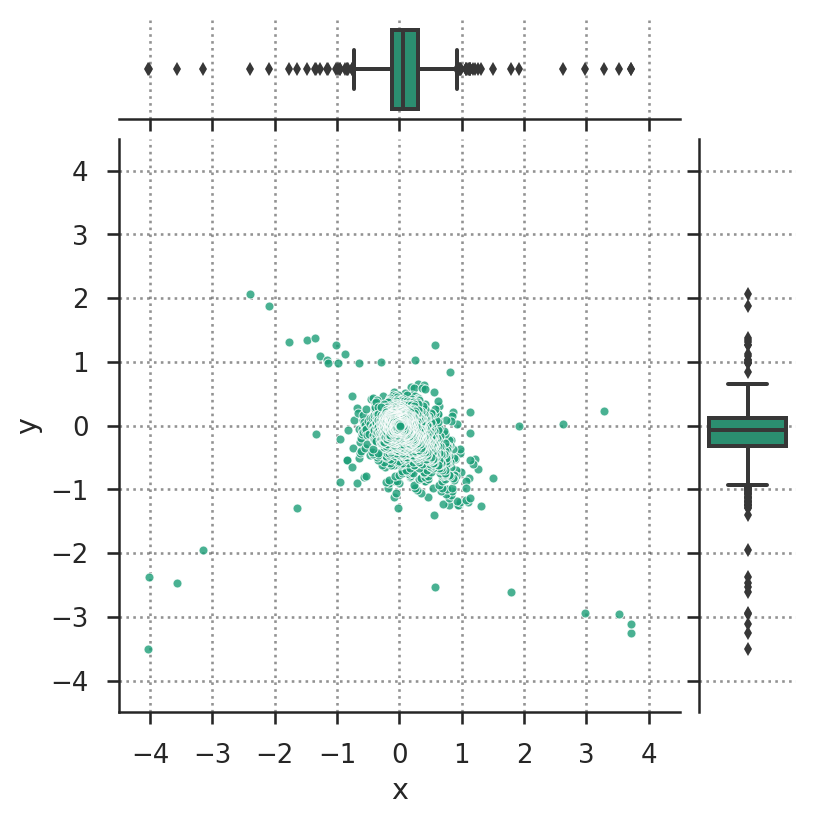

In [27]:
# based on https://github.com/mwaskom/seaborn/issues/1194
def marginal_boxplot(a, vertical=False, **kws):
    g = sns.boxplot(y='y', orient='v', **kws) if vertical else sns.boxplot(x='x', orient='h', **kws)
    g.set_ylabel('')
    g.set_xlabel('')
    
grid = sns.JointGrid(x='x', y='y', data=cropped_df)


grid.plot_marginals(marginal_boxplot, data=cropped_df, linewidth=2.0)
grid.plot_joint(sns.regplot, fit_reg=False,
                scatter_kws={'s': 20, 'edgecolor': 'w', 'linewidth': .5, 'alpha': .8})

grid.ax_joint.set_xlim(*CROPPED_LIMITS)
grid.ax_joint.set_ylim(*CROPPED_LIMITS)
grid.ax_joint.set_xticks(CROPPED_TICKS)
grid.ax_joint.set_yticks(CROPPED_TICKS)

grid.savefig('/output/figure.cropped.seaborn.pdf')

In [28]:
%%R -i cropped_df -i cropped_df_plus_fake -i RANDOM_STATE -i CROPPED_LIMITS -i CROPPED_TICKS
set.seed(RANDOM_STATE)

base_size <- 6
label_size <- 1.5
point_size <- 0.2
line_width <- 1
tick_length_cm <- 0.1
tick_width <- 0.5
axes_line_width <- 0.5
boxplot_lwd <- 0.2
boxplot_outlier_size <- 0.1
repel_segment_size <- 0.05
box_padding <- 0.01
point_padding <- point_size / 3.14
max.iter <- 20000
segment_line_color=NA

p <- scatterplot(cropped_df, cropped_df_plus_fake, limits=CROPPED_LIMITS, ticks=CROPPED_TICKS, 
                 base_size=base_size, 
                 label_size=label_size,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_fancy',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter,
                 segment_line_color=segment_line_color,
                 nudge_x=cropped_df[,'nudge_x'],
                 nudge_y=cropped_df[,'nudge_y'],
                 repel=TRUE
                 )

ggsave('/output/figure.cropped.2inx2in.annotated.only.pdf', plot=p, width=2, height=2, units="in")

p2 <- scatterplot(cropped_df, cropped_df_plus_fake, limits=CROPPED_LIMITS, ticks=CROPPED_TICKS, 
                 base_size=base_size, 
                 label_size=label_size,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_all',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter,
                 segment_line_color=segment_line_color,
                 nudge_x=cropped_df[,'nudge_x'],
                 nudge_y=cropped_df[,'nudge_y'],
                 )

ggsave('/output/figure.cropped.2inx2in.all.pdf', plot=p2, width=2, height=2, units="in")

p3 <- scatterplot(cropped_df, cropped_df_plus_fake, limits=CROPPED_LIMITS, ticks=CROPPED_TICKS, 
                 base_size=base_size, 
                 label_size=NA,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_fancy',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter
                 )

ggsave('/output/figure.cropped.2inx2in.nolabels.pdf', plot=p3, width=2, height=2, units="in")

p4 <- scatterplot(cropped_df, cropped_df_plus_fake, limits=CROPPED_LIMITS, ticks=CROPPED_TICKS, 
                 base_size=base_size, 
                 label_size=NA,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_fancy',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter,
                 alpha=0.05,
                 )

ggsave('/output/figure.cropped.2inx2in.nolabels.transparent.pdf', plot=p4, width=2, height=2, units="in")

In [29]:
cropped_df[cropped_df['label'].isin(['BRCA1', 'BRCC36', 'BRCC45'])]

,x,y,label,group,gene,ank_repeat,label_fancy,label_normal,label_all,fontface,nudge_x,nudge_y
Protein IDs,,,,,,,,,,,,
P38398;Q5YLB2;A0A0U1RRA9;E9PH68;E7EWN5;Q3B891;E7EUM2;A0A0A0MSN1;E7ENB7;C9IZW4;E7EQW4;E9PC22;H0Y8D8;B7ZA85;G1UI37;K7EPC7;H0Y8B8;H0Y850,-1.358380,1.373063,BRCA1,BRCA1,BRCA1,False,BRCA1,,BRCA1,plain,0.00,0.43
A0A087WZR3;H9KVA9;A0A0D9SF50;P46736;X6RJS7,-1.023534,1.264596,BRCC36,BRCA1,BRCC3,False,BRCC36,,BRCC36,plain,0.35,0.83
Q9NXR7;F8W733;C9J2G0;A0A075B7D2,-0.874005,1.125585,BRCC45,BRCA1,BRE,False,BRCC45,,BRCC45,plain,0.20,0.40


## Plotting, full-figure

In [30]:

FULL_LIMITS = np.array([-8.5, 8.5])
FULL_TICKS = np.arange(-8, 9, 2, dtype=int)


FULL_PLOT_OUTPUT = os.path.join(OUTPUT_DIR, 'figure.full.pdf')
FULL_PLOT_OUTPUT_NOLABELS = os.path.join(OUTPUT_DIR, 'figure.full.nolabels.pdf')

full_df, full_df_plus_fake = prepare_data_for_plot(limits=FULL_LIMITS)

In [31]:
%%R -i full_df -i full_df_plus_fake -i RANDOM_STATE -i FULL_LIMITS -i FULL_TICKS
set.seed(RANDOM_STATE)

base_size <- 20
label_size <- 3
point_size <- 2.0
line_width <- 3
tick_length_cm <- 0.5
tick_width <- 1.5
axes_line_width <- 2
boxplot_lwd <- 1.0
boxplot_outlier_size <- point_size * 0.6
repel_segment_size <- 0.5
box_padding <- 0.01
point_padding <- 0.25
force <- 1.5
max.iter <- 20000
segment_line_color = 'Gray80'

p <- scatterplot(full_df, full_df_plus_fake, limits=FULL_LIMITS, ticks=FULL_TICKS, 
                 base_size=base_size, 
                 label_size=label_size,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_all',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter,
                 force=force,
                 use_fake_data=TRUE,
                 segment_line_color=segment_line_color,
                 )

ggsave('/output/figure.full.7inx7in.pdf', plot=p, width=7, height=7, units="in")

p2 <- scatterplot(full_df, full_df_plus_fake, limits=FULL_LIMITS, ticks=FULL_TICKS, 
                 base_size=base_size, 
                 label_size=NA,
                 point_size=point_size,
                 line_width=line_width,
                 axes_line_width=axes_line_width,
                 tick_length_cm=tick_length_cm,
                 boxplot_lwd=boxplot_lwd,
                 label_column='label_all',
                 repel_segment_size=repel_segment_size,
                 boxplot_outlier_size=boxplot_outlier_size,
                 tick_width = tick_width,
                 box_padding = box_padding,
                 point_padding = point_padding,
                 max.iter = max.iter
                 )

ggsave('/output/figure.full.7inx7in.nolabels.pdf', plot=p2, width=7, height=7, units="in")
# ggsave('/output/figure.cropped.4cmx6cm.png', plot=p, width=4, height=6, units="cm", dpi=1500)

# Excel output

In [32]:
data.columns

Index(['Label', 'Gene names', 'Protein names', 'Protein group',
       'Contains ANK repeat', 'Potentially misidentified', 'Has both ratios',
       'Ratio H/L normalized F (log2)', 'Ratio H/L normalized R (log2)',
       'Best MS/MS', 'Evidence IDs', 'Fasta headers', 'Identification type F',
       'Identification type R', 'Intensity', 'Intensity F', 'Intensity H',
       'Intensity H F', 'Intensity H R', 'Intensity L', 'Intensity L F',
       'Intensity L R', 'Intensity R', 'LFQ intensity H F',
       'LFQ intensity H R', 'LFQ intensity L F', 'LFQ intensity L R',
       'MS/MS IDs', 'Majority protein IDs', 'Mod. peptide IDs',
       'Mol. weight [kDa]', 'Number of proteins', 'Only identified by site',
       'Oxidation (M) site IDs', 'Oxidation (M) site positions', 'Peptide IDs',
       'Peptide counts (all)', 'Peptide counts (razor+unique)',
       'Peptide counts (unique)', 'Peptide is razor', 'Peptides', 'Peptides F',
       'Peptides R', 'Potential contaminant', 'Q-value', 'Ratio

In [33]:
MAIN_COLUMNS = ['Label', 'Gene names', 'Protein names', 'Majority protein IDs', 'Contains ANK repeat', 
                'Protein group',
                'Peptides', 'Sequence coverage [%]', 'Score', 
                'Ratio H/L normalized F (log2)', 
                'Ratio H/L normalized R (log2)',
                'Ratio H/L count F',
                'Ratio H/L count R']

SUPPLEMENTARY_EXCLUDED_COLUMNS = [
    'Label', 'Contains ANK repeat', 'Protein group', 
    'Best MS/MS', 'Evidence IDs', 'Fasta headers', 'Mod. peptide IDs', 'Peptide IDs', 'id' 
]




In [34]:
_data_reset = data.reset_index()
excel_main_table = _data_reset[MAIN_COLUMNS]

for c in SUPPLEMENTARY_EXCLUDED_COLUMNS:
    assert c in _data_reset.columns
    
excel_supplementary_table = _data_reset[_data_reset.columns.difference(SUPPLEMENTARY_EXCLUDED_COLUMNS)]

In [35]:
from xlsxwriter.utility import xl_rowcol_to_cell, xl_col_to_name

In [36]:
# Copy this from scatterplot.R
group_colours = {
   # "Other":'black',
    "TONSL":"#7570b3",
    "BRCA1":'#d95f02',
    "RAD18/SLF":'#66a61e',
    "ORC":'#e7298a',
}

In [37]:
writer = pd.ExcelWriter(os.path.join(OUTPUT_DIR, 'dataset.xlsx'), engine='xlsxwriter')

# Write data, without headers
excel_main_table.to_excel(writer, sheet_name='H4K20me2 pull-down', index=False, header=False, startrow=1)
excel_supplementary_table.to_excel(writer, sheet_name='Additional information', index=False, header=False, startrow=1)

# Get variables
workbook = writer.book
main_sheet = writer.sheets['H4K20me2 pull-down']
supplementary_sheet = writer.sheets['Additional information']

# Add headers ourselves (so we can control formatting)
header = workbook.add_format({'bold': True, 'text_wrap': True})
for i, col in enumerate(excel_main_table.columns):
    main_sheet.write(0, i, col, header)
for i, col in enumerate(excel_supplementary_table.columns):
    supplementary_sheet.write(0, i, col, header)


# Conditional formatting: bold ANK repeat containing datasets, colour rows by group
whole_data_start = 'A2'
last_row = len(excel_main_table)
whole_data_end = xl_rowcol_to_cell(last_row, len(excel_main_table.columns)-1)
ank_repeat_column = xl_col_to_name(list(excel_main_table.columns).index(COL_ANK_REPEAT))
group_column = xl_col_to_name(list(excel_main_table.columns).index(COL_GROUP))

format_bold = workbook.add_format({'bold': True})
format_groups = {group: workbook.add_format({'bg_color': colour}) for group, colour in group_colours.items()}

# ANK repeats
main_sheet.conditional_format(':'.join([whole_data_start, whole_data_end]),
                             {'type': 'formula',
                              'criteria': '=${}2=TRUE'.format(ank_repeat_column),
                              'format': format_bold})

# Groups
for group, format_ in format_groups.items():
    main_sheet.conditional_format('{0}2:{0}{1}'.format(group_column, last_row),
                                 {'type': 'formula',
                                  'criteria': '=${}2="{}"'.format(group_column, group),
                                  'format': format_})



ratio_cf_start =  xl_rowcol_to_cell(1, list(excel_main_table.columns).index(COL_RATIO_LOG2_FORWARD),)
ratio_cf_end =  xl_rowcol_to_cell(last_row, list(excel_main_table.columns).index(COL_RATIO_LOG2_REVERSE))
print(ratio_cf_start, ratio_cf_end)
max_val = excel_main_table[[COL_RATIO_LOG2_FORWARD, COL_RATIO_LOG2_REVERSE]].abs().max().max()
print(max_val)

max_color, mid_color, min_color = sns.color_palette('RdBu', 3).as_hex()
main_sheet.conditional_format(':'.join([ratio_cf_start, ratio_cf_end]), 
                             {'type':     '3_color_scale',
                              'mid_value': 0,
                              'mid_type': 'num',
                              'min_type': 'num',
                              'max_type': 'num',
                              'min_value': -max_val,
                              'max_value': max_val,
                              'min_color': min_color,
                              'max_color': max_color,
                              'mid_color': mid_color
                              })


COLUMN_WIDTHS = {'Gene names': 20,
                 'Protein names': 40}


for column, new_width in COLUMN_WIDTHS.items():
    index = list(excel_main_table.columns).index(column)
    
    main_sheet.set_column(index, index, new_width)

writer.save()

J2 K1336
7.83516615722


In [38]:
writer.sheets

{'Additional information': <xlsxwriter.worksheet.Worksheet at 0x7f7eeb5199e8>,
 'H4K20me2 pull-down': <xlsxwriter.worksheet.Worksheet at 0x7f7ee04b6f60>}